In [1]:
from metodos.SSLTree.utils.Experiments import estudio_w, plot_estudio_w, plot_estudio_w_expandido, w_heatmap, names

import numpy as np
from scipy.stats import rankdata
import os
from concurrent.futures import ThreadPoolExecutor

# Influencia del parámetro w

Previsiblemente, el parámetro w es muy dependiente del propio dataset. Relacionado del mismo modo con las suposiciones del aprendizaje Semi-Supervisado (en algún caso, SSLTree no mejorará un modelo supervisado).

In [2]:
# entropy = shannon
# gini
CRITERION = "entropy"

In [3]:
accuracies_wine = estudio_w("wine", parallel=True, criterion=CRITERION)

Dataset: wine P: 10 - DONE
Dataset: wine P: 20 - DONE
Dataset: wine P: 30 - DONE
Dataset: wine P: 40 - DONE
wine saved


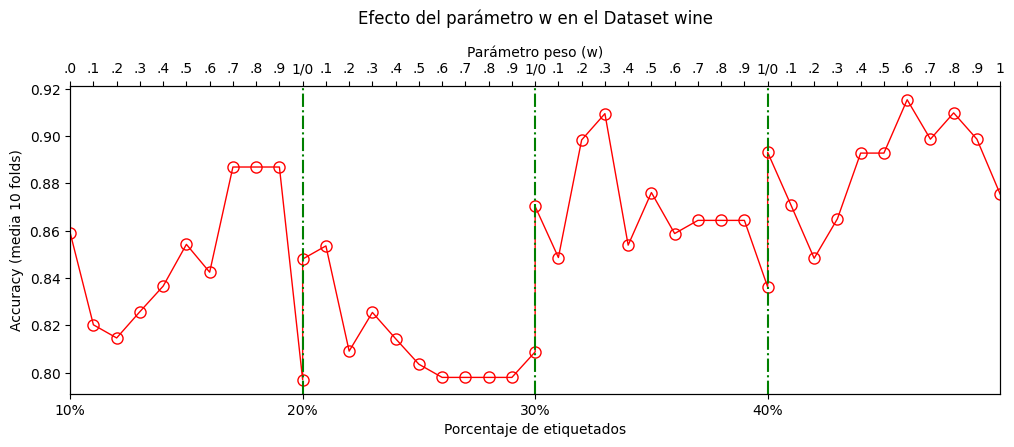

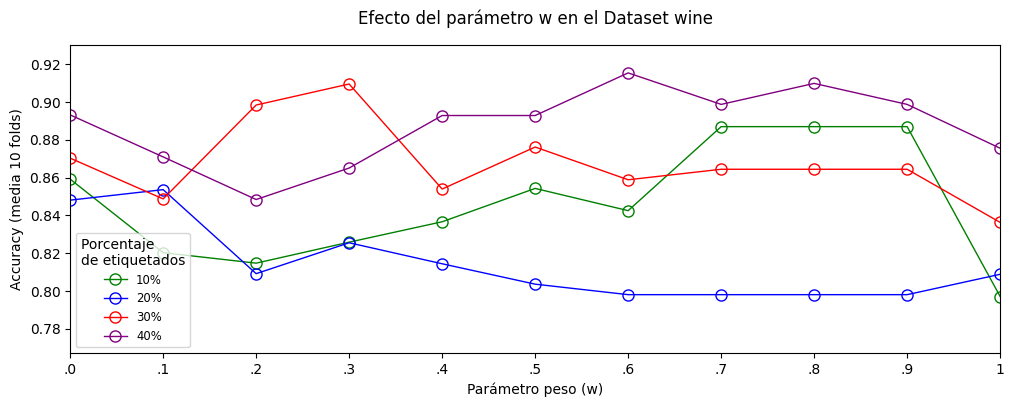

In [4]:
plot_estudio_w_expandido(accuracies_wine, "wine")
plot_estudio_w(accuracies_wine, "wine")

In [5]:
accuracies_tae = estudio_w("tae", parallel=True, criterion=CRITERION)

Dataset: tae P: 10 - DONE
Dataset: tae P: 20 - DONE
Dataset: tae P: 30 - DONE
Dataset: tae P: 40 - DONE
tae saved


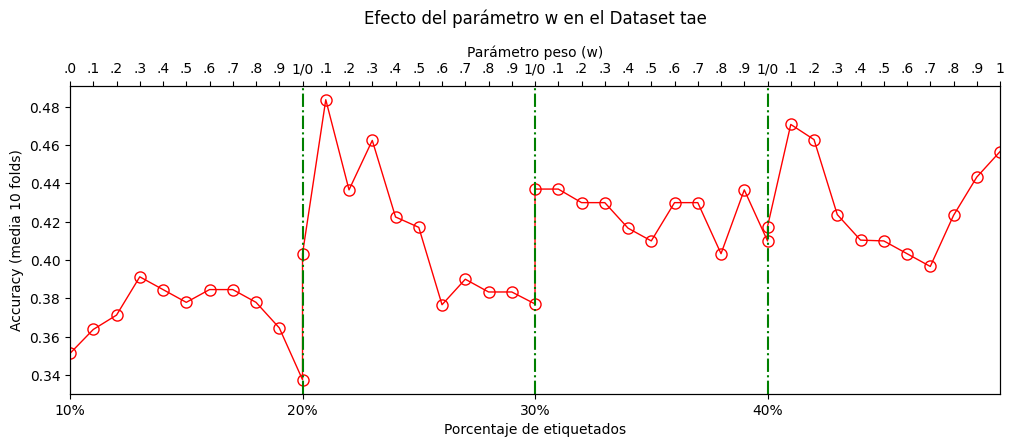

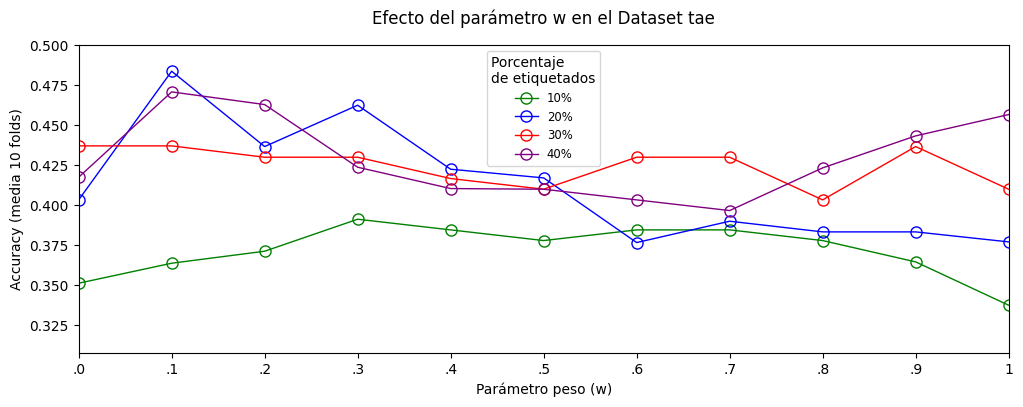

In [6]:
plot_estudio_w_expandido(accuracies_tae, "tae")
plot_estudio_w(accuracies_tae, "tae")

Tal y como los autores indicaron, el parámetro resulta ser muy dependiente del conjunto de datos.

Estos resultados indican:
- El parámetro w es beneficioso y **podría** mejorar el rendimiento del modelo con la salvedad de que, previsiblemente, para aquellos conjuntos de datos que no cumplan las suposiciones del semi-supervisado, el mejor modelo será un supervisado (parámetro w = 1).
- El porcentaje de etiquetados tiene un papel muy importante.
- Será necesario establecer un parámetro w personalizado para cada conjunto de datos.

# Experimentación parámetro w para cada dataset

Los resultados de este análisis servirán para extraer conclusiones del parámetros y seleccionar el mejor de ellos para iniciar después la comparación con otros modelos.

## Ejecutar todos los datasets

Los resultados se guardan en *experimentos/w/criterion*

In [4]:
def job(name):
     # El flip es para que las filas vayan de mayor w a menor w
    return np.flip(estudio_w(name, criterion=CRITERION).T, axis=0)

In [ ]:
num_cores = os.cpu_count()
print(num_cores)

with ThreadPoolExecutor(max_workers=int(num_cores * 0.8)) as executor:
    futures = {executor.submit(job, name): idx for idx, name in enumerate(names)}

## Ejecutar un único dataset (parallel)

In [13]:
ya_ejecutados = []

for filename in os.listdir(f"w/{CRITERION}"):
    ya_ejecutados.append(os.path.splitext(filename)[0])

print("Faltan por ejecutar: ", set(names) - set(ya_ejecutados))

Faltan por ejecutar:  {'twonorm', 'sonar', 'spectfheart', 'spambase', 'penbased', 'segment', 'vowel', 'movement_libras', 'marketing', 'phoneme', 'tic-tac-toe', 'satimage', 'thyroid', 'page-blocks', 'mammographic'}


In [5]:
estudio_w("iris", parallel=True, criterion=CRITERION)
np.load("w/iris.npy")

Dataset: iris P: 10 - DONE
Dataset: iris P: 20 - DONE
Dataset: iris P: 30 - DONE
Dataset: iris P: 40 - DONE
iris saved


array([[0.85333333, 0.88666667, 0.92666667, 0.92      ],
       [0.90666667, 0.93333333, 0.91333333, 0.9       ],
       [0.90666667, 0.91333333, 0.9       , 0.9       ],
       [0.9       , 0.9       , 0.9       , 0.9       ],
       [0.90666667, 0.9       , 0.9       , 0.9       ],
       [0.9       , 0.9       , 0.9       , 0.9       ],
       [0.89333333, 0.9       , 0.9       , 0.9       ],
       [0.89333333, 0.9       , 0.9       , 0.9       ],
       [0.89333333, 0.9       , 0.88      , 0.9       ],
       [0.89333333, 0.9       , 0.88666667, 0.89333333],
       [0.76666667, 0.79333333, 0.81333333, 0.79333333]])

## Recopilar todos los experimentos en una matriz

In [12]:
all_matrix = []

for filename in os.listdir(f"w/{CRITERION}"):
    all_matrix.append(np.load(f"w/{CRITERION}/" + filename))

all_matrix = np.array(all_matrix)
print(all_matrix.shape)

(24, 11, 4)


## Resultados de la experimentación

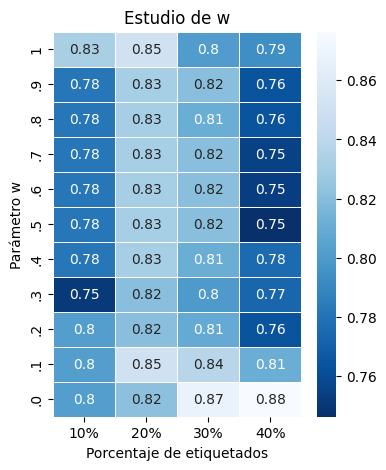

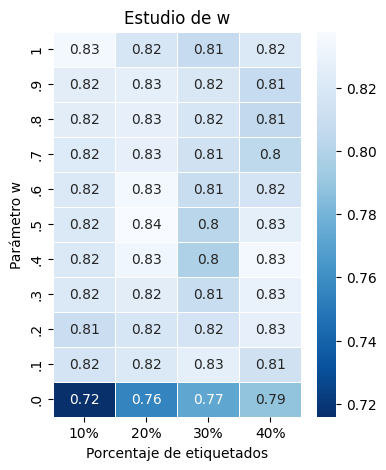

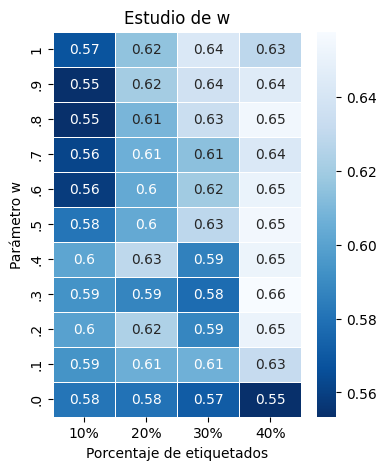

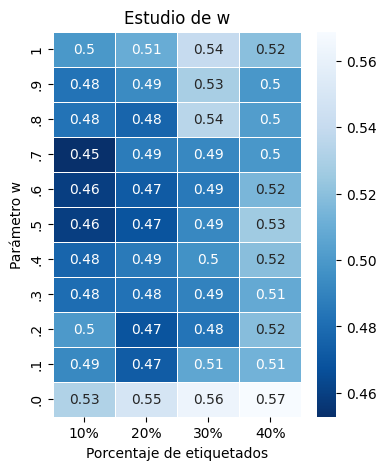

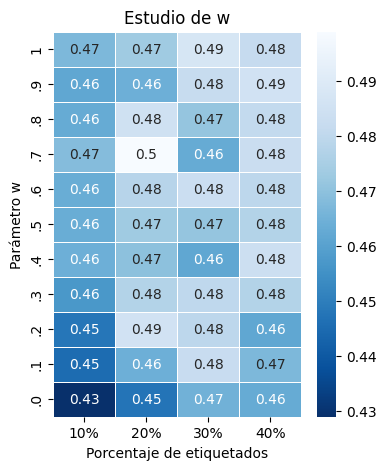

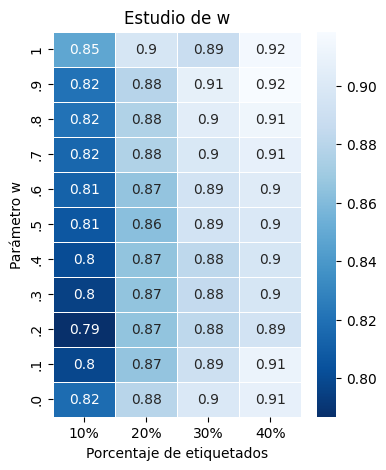

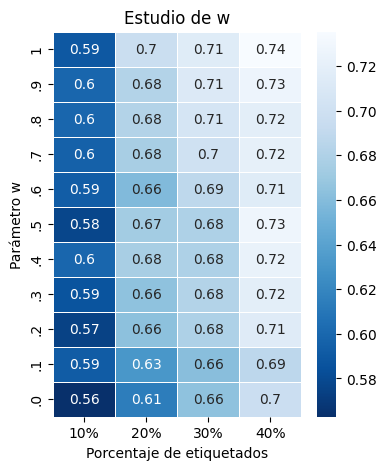

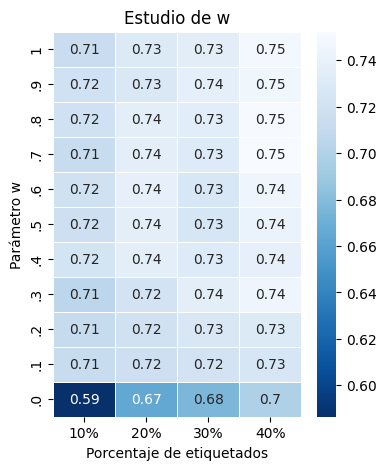

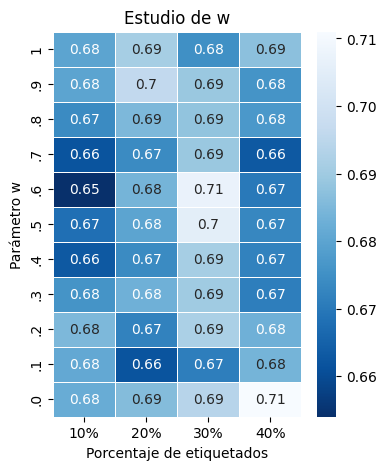

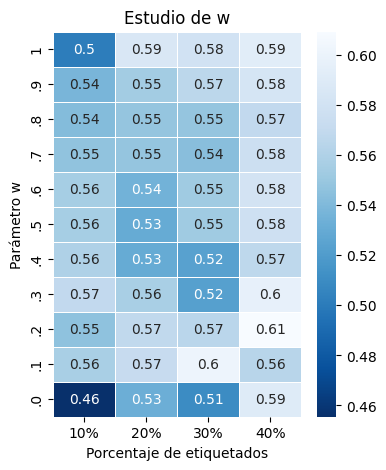

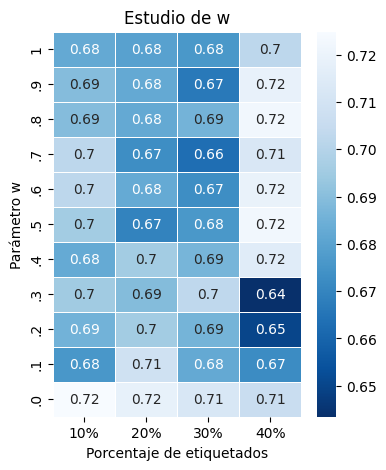

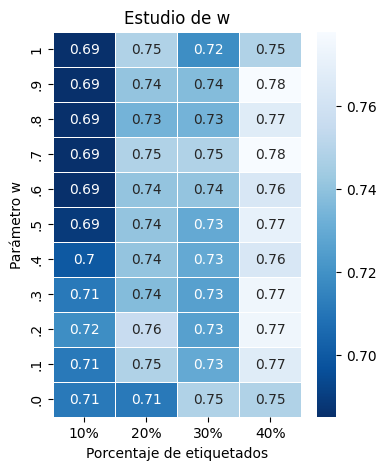

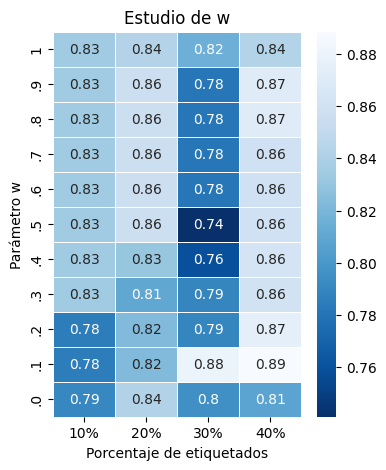

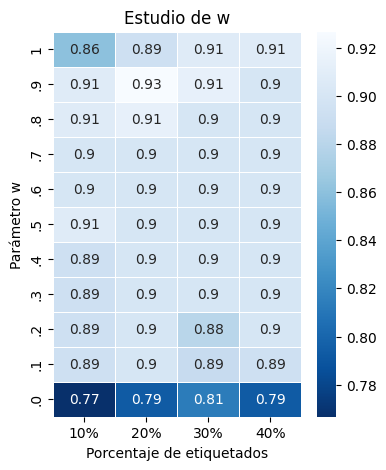

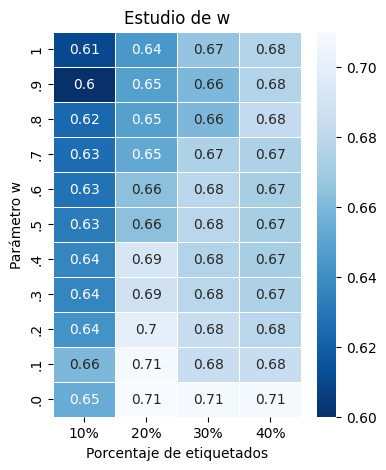

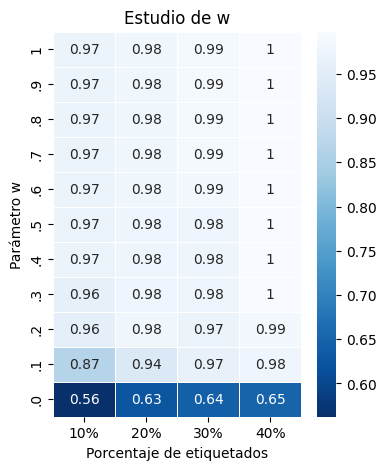

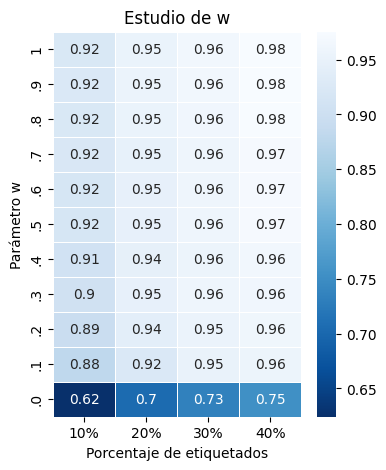

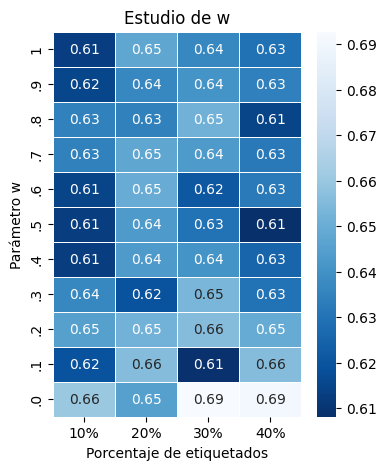

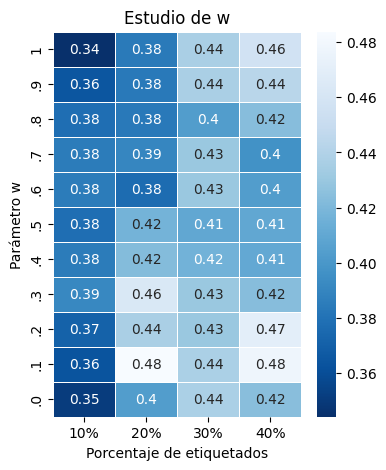

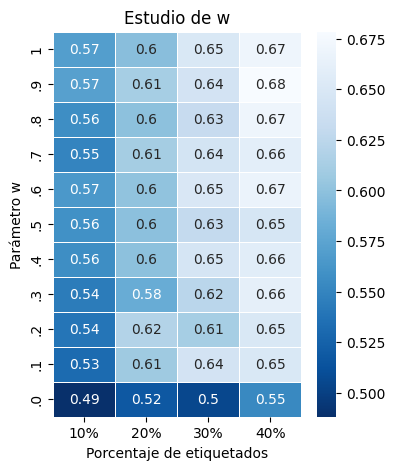

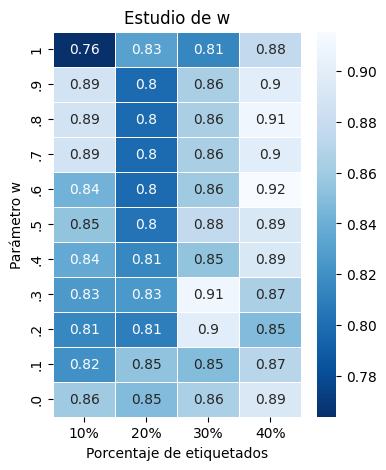

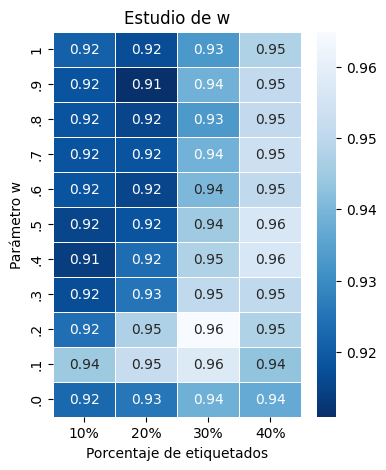

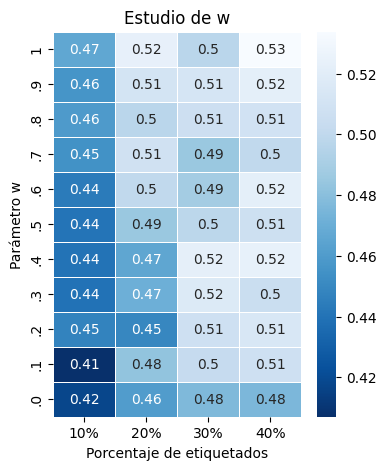

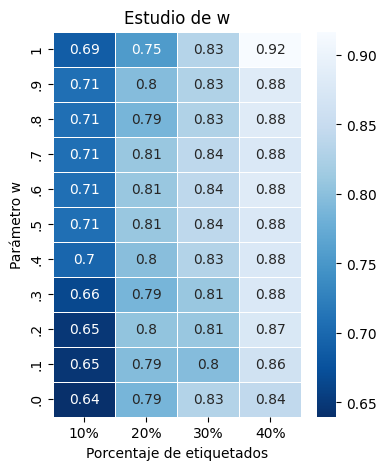

In [13]:
for a in all_matrix:
    w_heatmap(a)

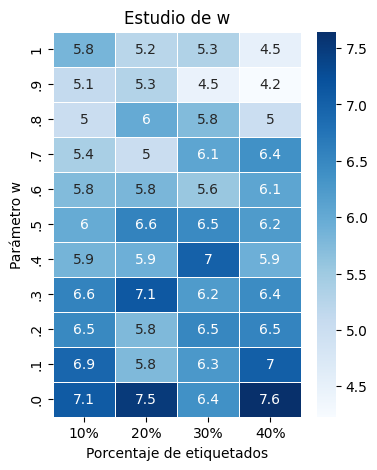

In [14]:
all_rankings = []
for a in all_matrix:
    all_rankings.append(rankdata(-a, axis=0))
    
w_heatmap(np.mean(all_rankings, axis=0), less_better=True)

## Nemenyi Test

Comprobar la existencia de diferencias significativas

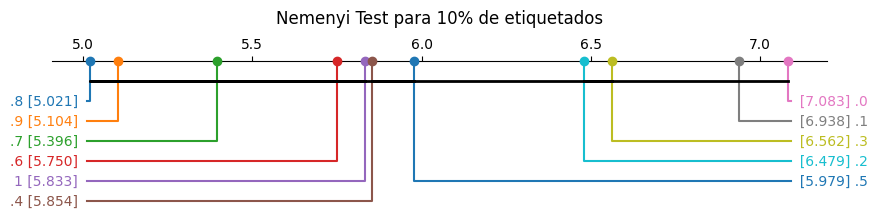

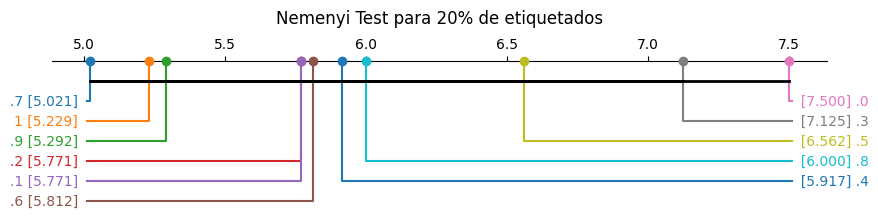

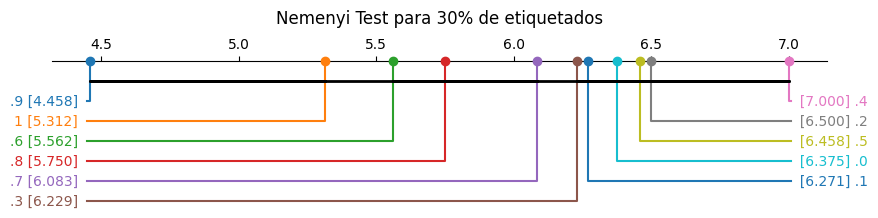

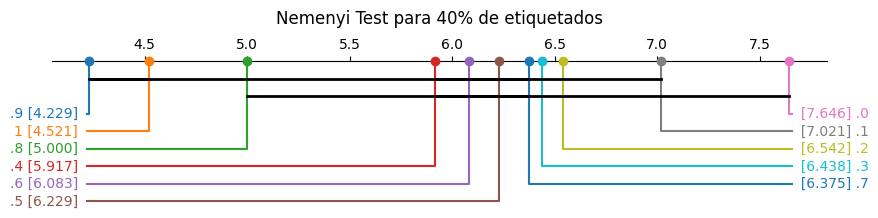

In [15]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import scikit_posthocs as sp


def nemenyi_test(matrix):
    
    tests = ["10%", "20%", "30%", "40%"]
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i in range(matrix.shape[2]):
            dict_data = {
                '1': all_matrix[:, 0, i],
                '.9': all_matrix[:, 1, i],
                '.8': all_matrix[:, 2, i],
                '.7': all_matrix[:, 3, i],
                '.6': all_matrix[:, 4, i],
                '.5': all_matrix[:, 5, i],
                '.4': all_matrix[:, 6, i],
                '.3': all_matrix[:, 7, i],
                '.2': all_matrix[:, 8, i],
                '.1': all_matrix[:, 9, i],
                '.0': all_matrix[:, 10, i],
            }
            
            data_list = [dict_data[key] for key in dict_data]
            
            results = np.array(data_list).T
            
            nemenyi_result = sp.posthoc_nemenyi_friedman(results)
            
            ranks = pd.DataFrame(-results).rank(axis=1, method='average').mean(axis=0)
            ranks.index = list(dict_data.keys())
            
            plt.figure(figsize=(10, 2), dpi=100)
            plt.title("Nemenyi Test para " + tests[i] + " de etiquetados", pad=10)
            sp.critical_difference_diagram(ranks, nemenyi_result, label_fmt_left='{label} [{rank:.3f}]  ',
                                           label_fmt_right='  [{rank:.3f}] {label}')
            plt.show()
        
nemenyi_test(all_matrix)